# **Spotify Song Genre Prediction**
#### **DSCI 100 Section 007**
#### **Group 5 Project Proposal**

## Introduction

One of the world's most well-known music streaming services, Spotify offers a web API with the ability to collect several audio features for any song found on Spotify. In this project, we use a **[dataset](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db)** created by Zaheen Hamidani using the Spotify API. In this project, our group will pursue the viability of genre-based music sorting using audio features such as beats per minute, acoustics, and tempo. In essence, we want to explore the realm of classification regarding music and the various musical genres that songs may fall into. Using data derived from Spotify, our group aims to demonstrate a cohesive understanding of course material and proficiently accomplish this feat.\
\
**Inference Question:** Can a song's audio features be used to correctly classify its musical genre using a simple k-NN model?
* The possible predictor variables that are displayed via this avenue of evaluation are as follows:
    * track_id (unique identifier)
    * popularity
    * acousticness (measure of acoustic presence)
    * danceability (0 to 1 of how danceable a song is)
    * duration_ms
    * energy (measure of intensity and activity)
    * instrumentalness (measure of whether a track contains no vocals or not)
    * key (note range)
    * liveness (was this track played live at a venue?)
    * loudness (decibels)
    * mode (major or minor key)
    * speechiness (amount of spoken words)
    * tempo (beats per minute)
    * time_signature
    * valence (musical positiveness conveyed by a track)
* More detailed variable descriptions are available **[here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features)**

## Exploratory Data Analysis

In [51]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 8)

In [52]:
song_data <- read_csv("https://github.com/aidanmeharg/dsci-100-2022W2-group-5/raw/main/data/SpotifyFeatures.csv")

song_data <- song_data |>
    mutate(genre = as_factor(genre)) |> 
    mutate(key = as_factor(key)) |>
    mutate(time_signature = as_factor(time_signature)) |>
    mutate(mode = as_factor(mode))

song_data

Rows: 232725 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): genre, artist_name, track_name, track_id, key, mode, time_signature
dbl (11): popularity, acousticness, danceability, duration_ms, energy, instr...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.0329,0.785,282447,0.683,8.80e-04,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969
Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.9010,0.517,166960,0.419,0.00e+00,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813
Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.2620,0.745,222442,0.704,0.00e+00,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489
Soul,Mint Condition,You Don't Have To Hurt No More,34XO9RwPMKjbvRry54QzWn,35,0.0973,0.758,323027,0.470,4.89e-05,G#,0.0836,-6.708,Minor,0.0287,113.897,4/4,0.479


### Check for Songs Classified Under Multiple Genres

copies,count
<int>,<int>
1,141650
2,21871
3,8091
4,3374
5,1300
6,358
7,124
8,6


[1] 176774

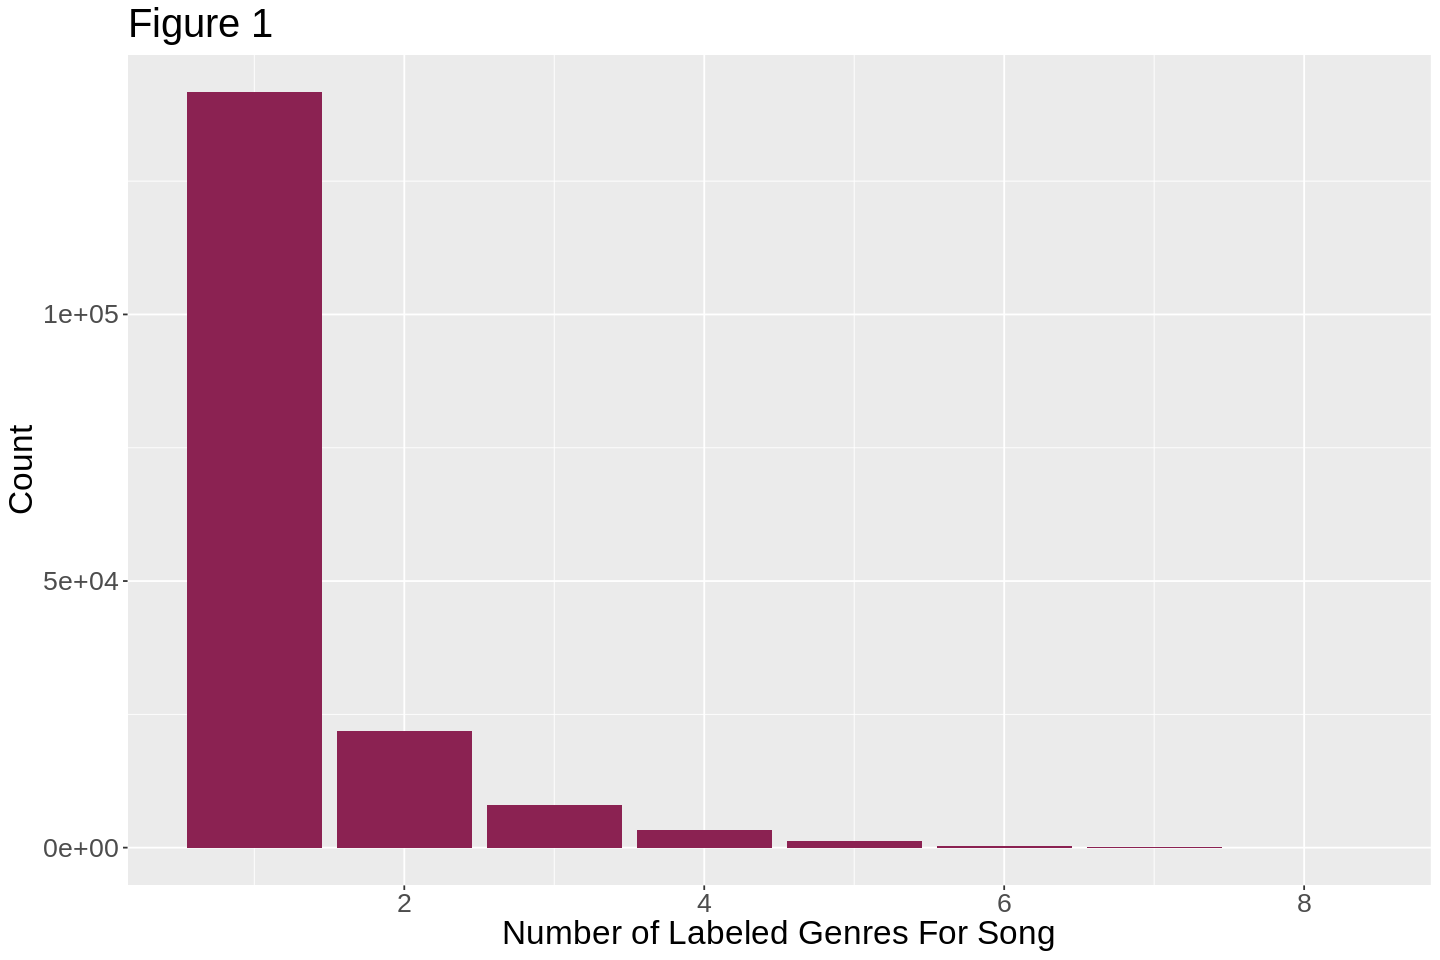

In [53]:
song_copies <- song_data |>
    group_by(track_id) |>
    summarize(copies = n()) |>
    arrange(desc(copies)) 

song_copy_counts <- song_copies |>
    group_by(copies) |>
    summarize(count = n())

num_unique_track_ids <- song_copy_counts |>
    select(count) |>
    pull() |>
    sum()

song_copy_counts
num_unique_track_ids

ggplot(song_copy_counts, aes(copies, count))+
    geom_bar(stat = "identity", fill = "violetred4")+
    labs(x = "Number of Labeled Genres For Song", y = "Count")+
    ggtitle("Figure 1")+
    theme(text = element_text(size = 20))

There are a total of 176,774 unique tracks in this dataset. Of those tracks, 141,650 (~80%) fall under a single genre classification while the rest appear in as many as eight different genres! Having songs that fall into multiple genres will complicate the classification process, so for this project we decided to only use songs with one assigned genre.

In [54]:
multi_genre_songs <- song_copies |>
    filter(copies > 1) |>
    select(track_id) |>
    pull()

song_data <- song_data |>
    filter(!(track_id %in% multi_genre_songs))

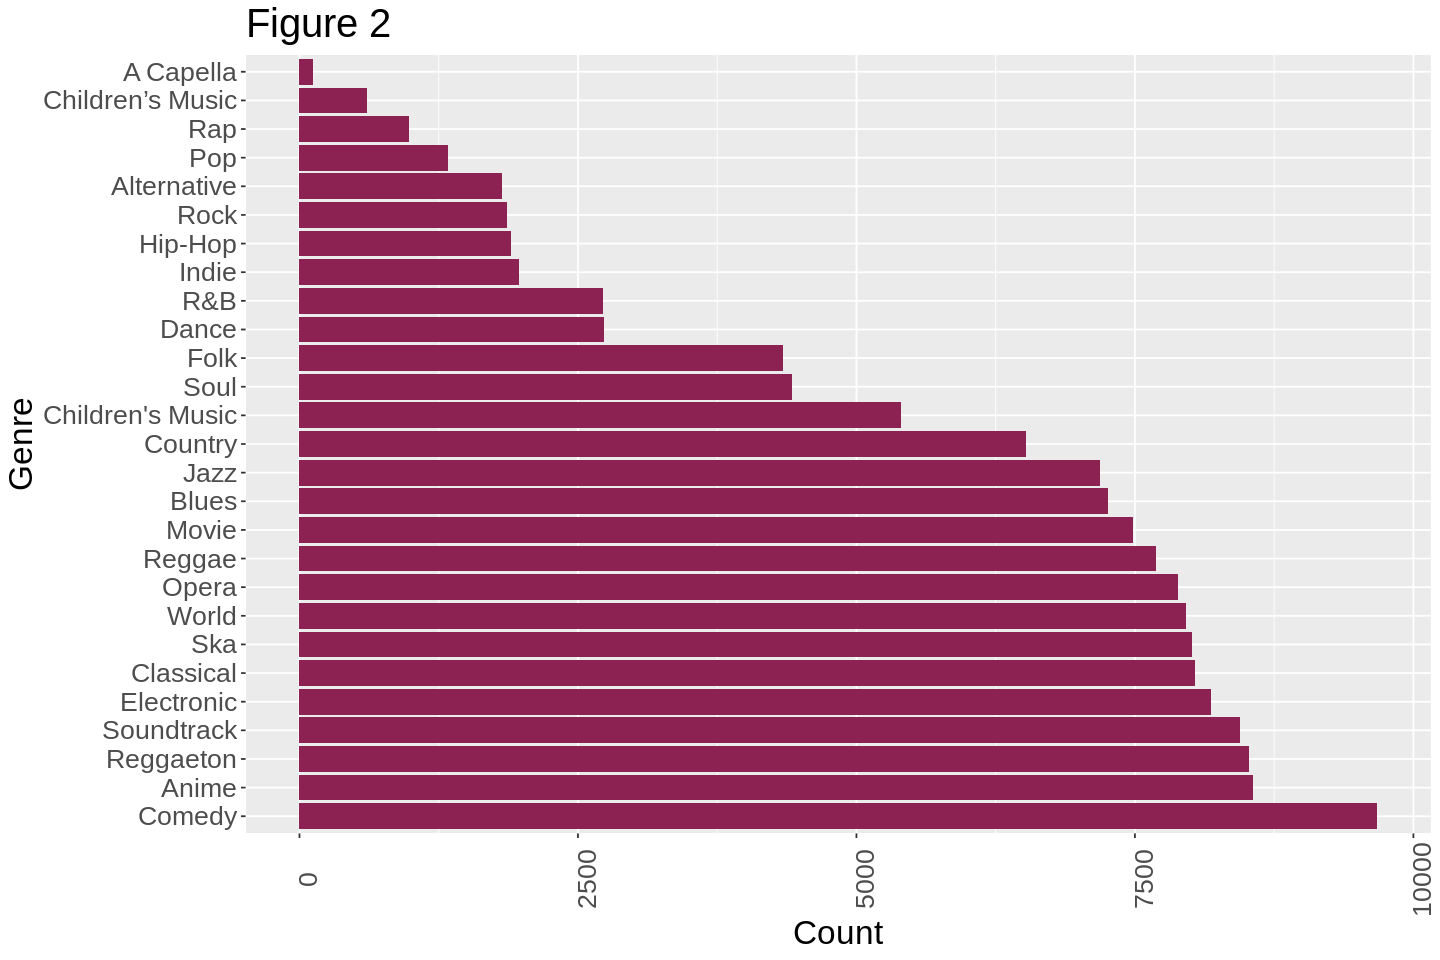

In [55]:
options(repr.plot.height = 8, repr.plot.width = 12)

genre_plot <- song_data |>
    group_by(genre) |>
    summarize(count = n()) |>
    ggplot(aes(reorder(genre, -count), count))+
        geom_bar(stat = "identity", fill = "violetred4")+
        labs(x = "Genre", y = "Count")+
        ggtitle("Figure 2")+
        coord_flip()+
        theme(text = element_text(size = 20), axis.text.x = element_text(angle = 90))

genre_plot

As seen on the above graph there is a problem regarding the genre of Children's Music. It seems to be classified into two genres because of the apostrophe: one is Children's Music and the other is Children’s Music. We will correct this and put both of them under the same category as they should be. We also remove A Capella songs from our analysis entirely due to a very low number of observations.

In [56]:
#Checking how many songs and genres are in the data set
Original_number_Of_songs <-nrow(song_data)
Original_number_Of_Genere <- song_data |>
                            group_by(genre) |>
                            summarize(count = n()) |> 
                            nrow()
print(paste("Number of Rows of the original data set: ", Original_number_Of_songs))
print(paste("Number of genres of the original Data set: ", Original_number_Of_Genere))
#We select one of the two genre classify as children songs and mutate them to the other name of Children's Music
selectingOneTypeOfChildrensSong <- song_data |>
                                filter(genre=="Children’s Music") |>
                                mutate(genre=factor("Children's Music"))

#We delete that said genre from the original data set
song_data <- song_data |> 
            filter(genre!="Children’s Music")


[1] "Number of Rows of the original data set:  141650"
[1] "Number of genres of the original Data set:  27"


In [57]:
#We merge both of them into one data set
song_data <-add_row(song_data, selectingOneTypeOfChildrensSong)

#Confirm they have the same number of rows
New_number_of_songs<-nrow(song_data)
print(paste("Number of Rows of the new data set: ", New_number_of_songs))
#Confirm the have one genre less
New_number_Of_Genere <- song_data |>
                            group_by(genre) |>
                            summarize(count = n()) |>
                            nrow()
print(paste("Number of genres of the new Data set: ", New_number_Of_Genere))

[1] "Number of Rows of the new data set:  141650"
[1] "Number of genres of the new Data set:  26"


In [58]:
# Remove the A Capella songs (too few observations)
song_data <- song_data |>
    filter(genre != "A Capella")

### Training / Testing Split

- Due to the size of the data set(1416450) different songs and knowing that one of the disadvtanges of uses knn is that the larger the data set the more time it can take, we are going to take a represnetative sample and based our result on it.

**Don't Forget To Run This**

In [59]:
set.seed(1738)

In [62]:
song_split <- initial_split(song_data, prop = 0.01, strata = genre)
song_train <- training(song_split)
song_test <- testing(song_split)
print(nrow(song_train))

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


[1] 1415


**Not sure why this warning message keeps occurring.**
The splits appear to keep original proportions quite well.

In [63]:
colSums(is.na(song_train))

genre      artist_name       track_name         track_id 
               0                0                0                0 
      popularity     acousticness     danceability      duration_ms 
               0                0                0                0 
          energy instrumentalness              key         liveness 
               0                0                0                0 
        loudness             mode      speechiness            tempo 
               0                0                0                0 
  time_signature          valence 
               0                0

There appear to be no missing (NA) values in our training set.

In [64]:
continuous_predictors <- song_train |>
    select(popularity:valence) |>
    select(-c("key", "mode", "time_signature")) 
summary_table <- apply(continuous_predictors, 2,  summary)
summary_table

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
Min.,0.00000,0.00000128,0.0639000,18000.0,0.0010100,0.0000000,0.0236000,-39.99600,0.0237000,47.3990,0.0266000
1st Qu.,21.00000,0.05610000,0.3940000,171658.0,0.3180000,0.0000000,0.1000000,-13.79750,0.0374000,90.8450,0.2220000
Median,33.00000,0.35000000,0.5420000,218147.0,0.5840000,0.0001700,0.1360000,-9.05500,0.0503000,114.3370,0.4480000
Mean,31.38516,0.43753093,0.5242866,239157.1,0.5444597,0.1939427,0.2400933,-10.74125,0.1412159,116.9701,0.4538466
3rd Qu.,42.00000,0.82700000,0.6690000,270598.0,0.7895000,0.2010000,0.3060000,-5.87600,0.1030000,139.1020,0.6740000
Max.,83.00000,0.99600000,0.9640000,3752800.0,0.9960000,0.9800000,0.9900000,1.01200,0.9620000,200.3370,0.9830000


#### Table 1

We can see that most of the continuous features created by spotify have been normalized via min-max scaling, as they are in the interval [0,1] (they have not been zero-centered however). Tempo, loudness, and duration have not been scaled or centered. Histograms are provided for each of the continuous predictors below (figure 3).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



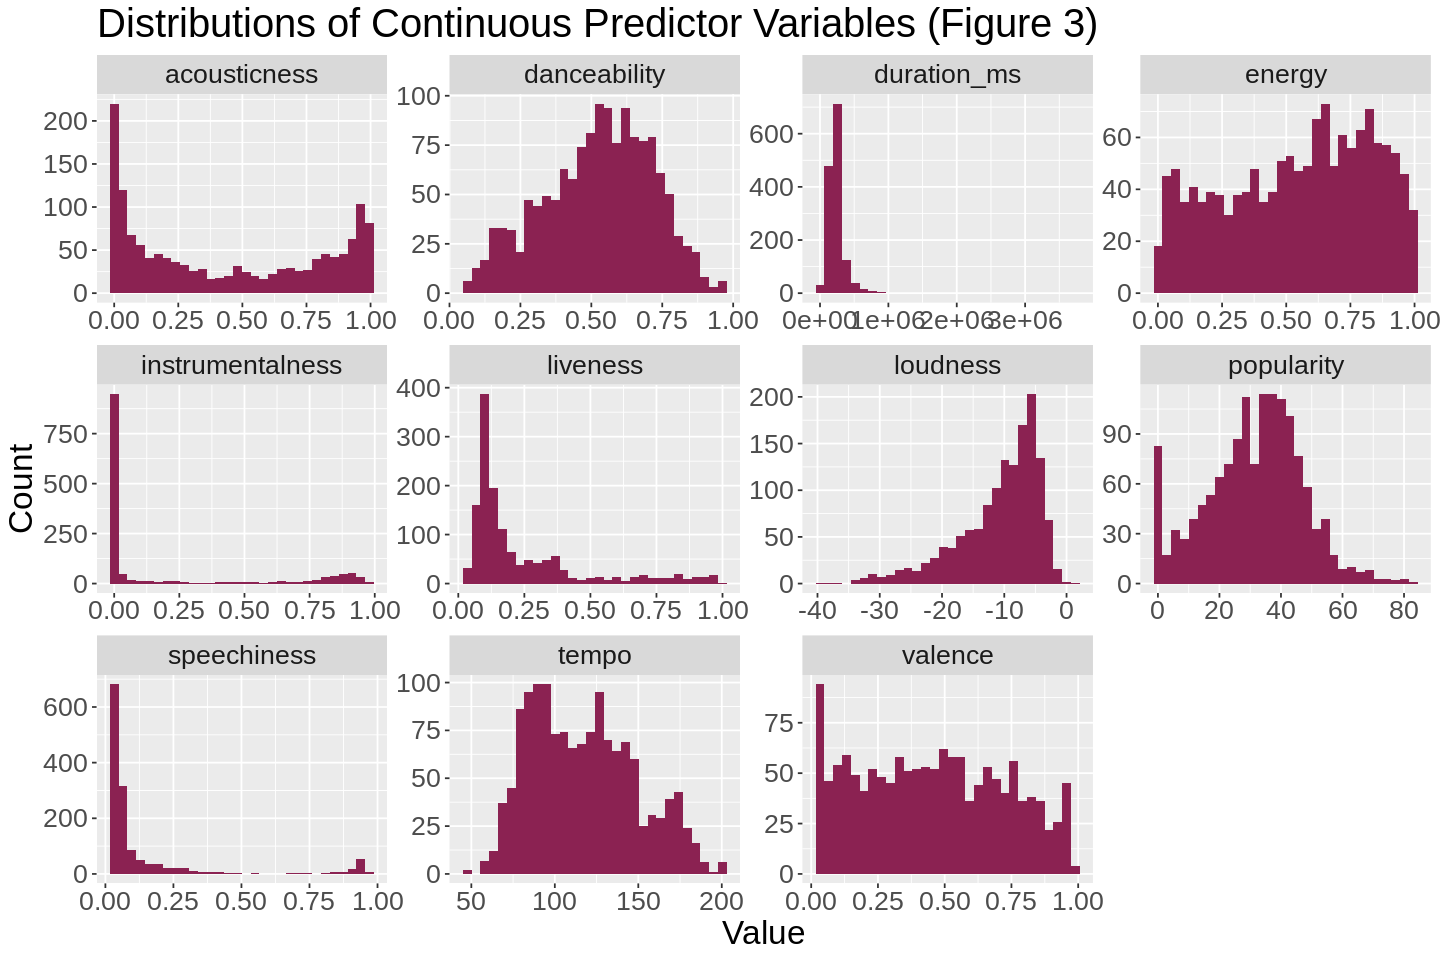

In [65]:
options(repr.plot.height = 8, repr.plot.width = 12)

continuous_long <- continuous_predictors |>
    pivot_longer(colnames(continuous_predictors))

density_plots <- continuous_long |>
    ggplot(aes(value)) +
        geom_histogram(fill = "violetred4") +
        facet_wrap(~name, scales = "free")+
        labs(x = "Value", y = "Count") +
        ggtitle("Distributions of Continuous Predictor Variables (Figure 3)") + 
        theme(text = element_text(size = 20))

density_plots

We notice that song duration (duration_ms) appears to have some very high outlier values. These may need to be removed in preprocessing. In addition, several of the predictors appear to have very skewed distributions which we may dampen in the future via log transformation.

In [18]:
options(repr.plot.height = 8, repr.plot.width = 14)

ggcorr(continuous_predictors, method = c("pairwise", "pearson"), hjust = 0.75, size = 5, layout.exp = 1,
      label = TRUE, label_round = 2, legend.position = c(0.2, 0.6), name = "Pearson Correlation", legend.size = 15)+
        ggtitle("Pearson Correlation of Continuous Predictors (Figure 4)")+
        theme(text = element_text(size = 20))

ERROR: Error in ggcorr(continuous_predictors, method = c("pairwise", "pearson"), : could not find function "ggcorr"


The above correlation heatmap (Figure 4) displays Pearson correlation coefficients between each of the continuous predictors. We note that there is a strong positive correlation between loudness and energy (which makes sense). There are also moderately strong negative correlations between energy-acousticness and loudness-acousticness. We will keep this collinearity in mind if we want to reduce the number of predictors in the future.

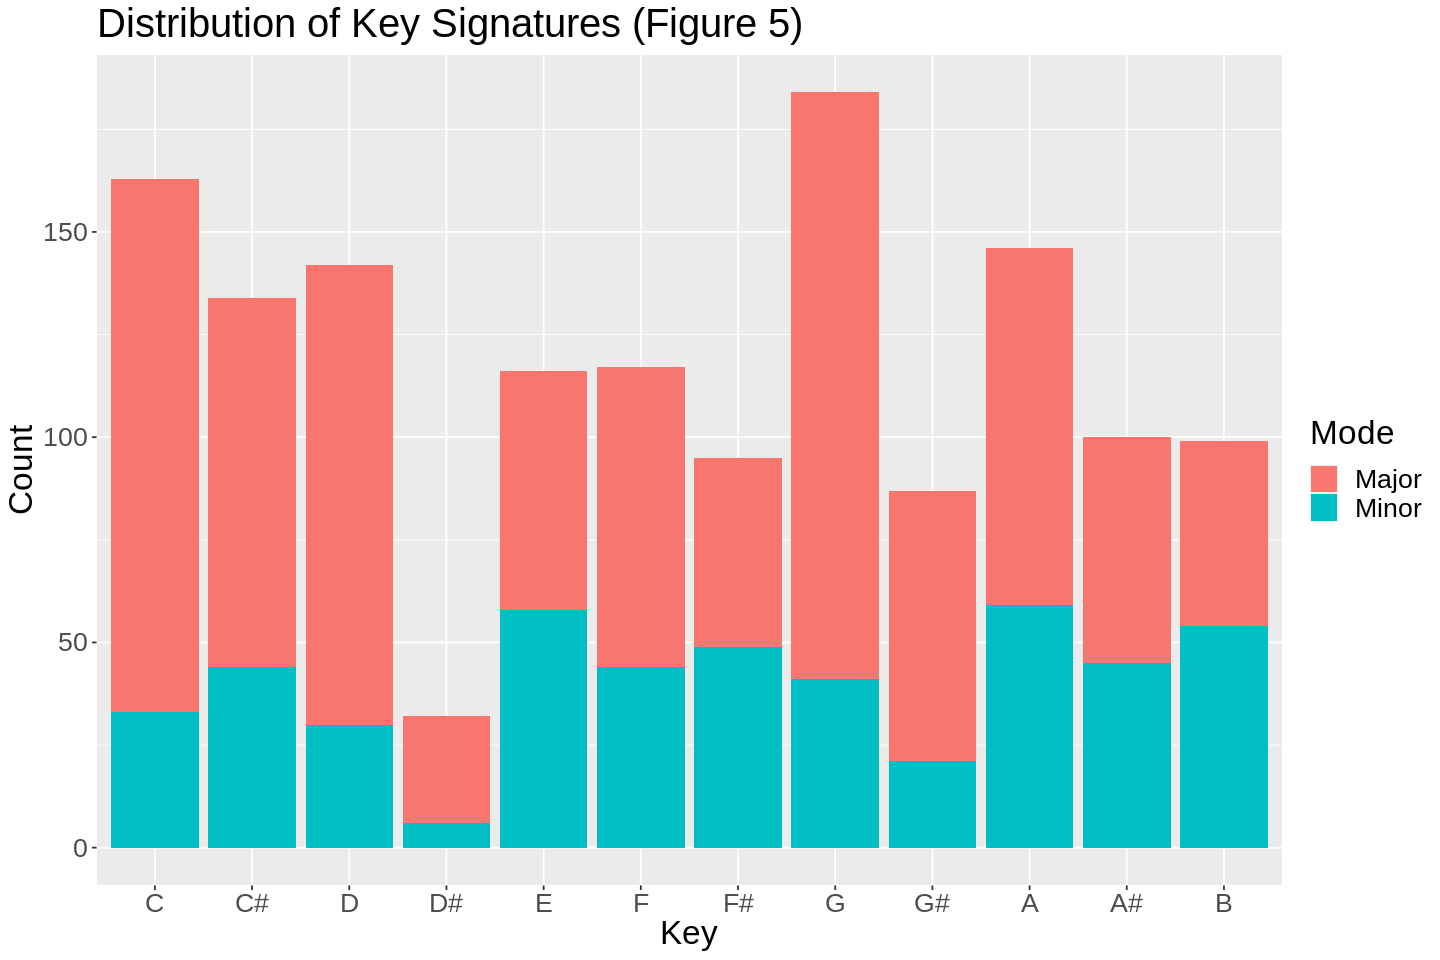

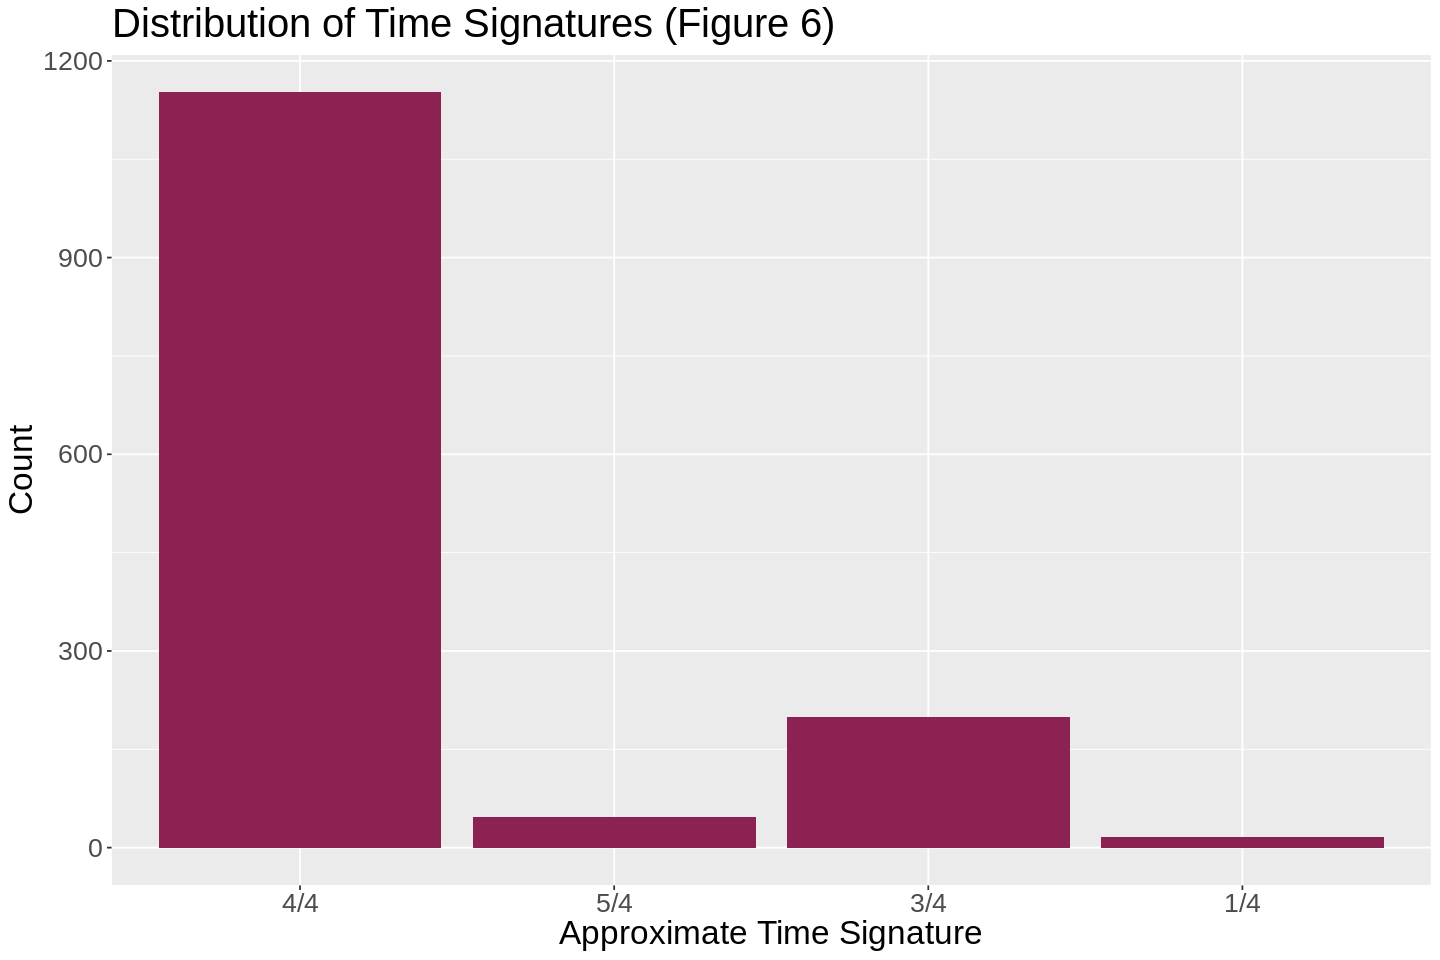

In [66]:
categorical_predictors <- song_train |>
    select(c("key", "mode", "time_signature"))

categorical_predictors$key <- fct_relevel(categorical_predictors$key, "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B")

key_plot <- categorical_predictors |>
    group_by(key, mode) |>
    tally() |>
    ggplot(aes(key, n, fill = mode)) +
        geom_bar(stat = "identity") +
        labs(x = "Key", y = "Count", fill = "Mode")+
        ggtitle("Distribution of Key Signatures (Figure 5)")+
        theme(text = element_text(size = 20))

time_sig_plot <- categorical_predictors |>
    group_by(time_signature) |>
    tally() |>
    ggplot(aes(time_signature, n)) +
        geom_bar(stat = "identity", fill = "violetred4") +
        labs(x = "Approximate Time Signature", y = "Count") +
        ggtitle("Distribution of Time Signatures (Figure 6)")+
        theme(text = element_text(size = 20))

key_plot
time_sig_plot

The description of time_signature from Spotify web API indicates that time signatures should range from 3/4 to 7/4, so it is concerning that there are some songs classified under 1/4. It is unclear what the dataset creator has done to alter the values obtained from the Spotify API.

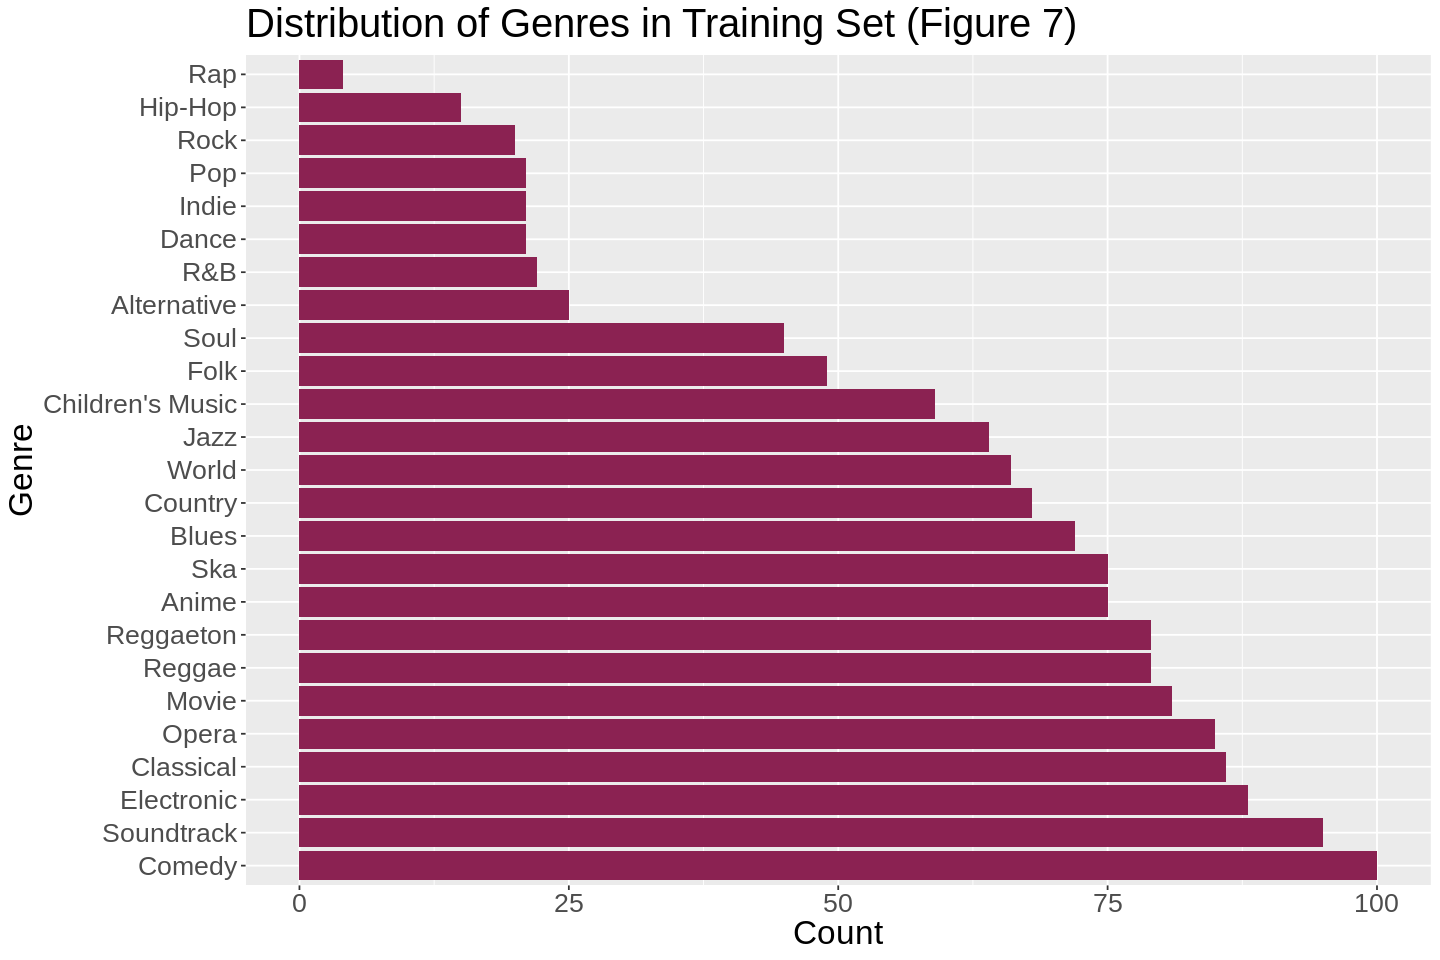

In [67]:
genre_dist_plot <- song_train |>
    group_by(genre) |>
    summarize(count = n()) |>
    ggplot(aes(reorder(genre, -count), count))+
        geom_bar(stat = "identity", fill = "violetred4")+
        labs(x = "Genre", y = "Count")+
        ggtitle("Distribution of Genres in Training Set (Figure 7)")+
        coord_flip()+
        theme(text = element_text(size = 20))

genre_dist_plot

## Methods

- We will do classification using k nearest neighbors, but to accurately predict these we will choose to remove variables that do not contribute anything useful for the model:
    - Track_id: It is a identifier, has no predictive power
    - Track_name: Does not help the model as having the same name does not represent anything special.  
    - Artist_name: Having the same artist, does not guarantee you are going to have the same genre, bands like Linkin Park used to be a rock band now it is a pop band. We would also like our model to be able to predict genres for new artists to help them connect with new listeners 
    - Popularity: We want to be able to predict genres for small/new artists, thus we will not use this as a predictor
    - Liveness: Audience prescence in the song logically should not have bearing on its genre, as any song can be put into a concert and be classified as lively.  
- After this we will normalize and center all of the selected variables, as not all of them are measured under the same scale or centered around the same value. This is an especially important step when using k-NN models which are inherently distance based.
#### Visualization:
- A great way to vizualize the results is to have a bar graph or percent of songs we accurately predict based on genre to see if the model was better or worse for specific set of genres 

### Removing the unncesary Variables

In [68]:
song_train<- song_train |>
            select(-track_id, -track_name, -artist_name, -popularity, -liveness)
song_train

genre,acousticness,danceability,duration_ms,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
Movie,0.7510,0.906,111467,0.438,0.00e+00,D,-12.489,Major,0.0468,127.900,4/4,0.970
Movie,0.0282,0.653,158067,0.732,9.73e-05,B,-6.882,Minor,0.0258,110.024,4/4,0.358
Movie,0.6510,0.248,177320,0.341,0.00e+00,A#,-9.652,Major,0.0348,186.810,4/4,0.518
Country,0.0925,0.608,291467,0.649,8.49e-05,F#,-7.876,Minor,0.1900,167.936,4/4,0.505
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Soul,0.0846,0.746,168639,0.360,2.35e-04,F#,-9.370,Minor,0.0303,106.027,4/4,0.415
Soul,0.0430,0.684,351867,0.636,0.00e+00,G#,-6.152,Minor,0.0473,109.770,4/4,0.571
Children's Music,0.0010,0.510,274615,0.862,4.28e-06,G,-5.105,Major,0.0280,156.126,4/4,0.461
Children's Music,0.2170,0.741,164373,0.526,3.61e-06,C#,-7.001,Minor,0.0520,119.944,4/4,0.548


### Creating the KNN model

In [69]:
#First we will create the folds so we can cross validate to check for the best number of neighbors
song_fold<-vfold_cv(song_train, v=5, strata=genre)
#second we create the recipe
song_recipe<- song_train |>
                recipe("genre~.") |>
                step_scale(all_numeric())|>
                step_center(all_numeric())
song_recipe
#lets create the model
song_model <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
                set_engine("kknn") |>
                set_mode("classification")
song_model
#lets create k values 
neighrbos = tibble(neighbors=seq(1, 10))
#lets create the fit
song_fit <- suppressWarnings(workflow() |>
                add_recipe(song_recipe) |>
                add_model(song_model) |>
                tune_grid(resamples = song_fold, grid = neighrbos) |>
                collect_metrics() |>
                filter(.metric == "accuracy") |>
                arrange(desc(mean)) |>
                slice_head(n = 1) |>
                summarize(my_string = paste("neighbors:", neighbors, "accuracy =", round(mean, 4))) |>
                pull(my_string))

print(song_fit)

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


Recipe

Inputs:

      role #variables
   outcome          1
 predictor         12

Operations:

Scaling for all_numeric()
Centering for all_numeric()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "neighbors: 10 accuracy = 0.3357"


- Based on this results lets try to tune the parameters used in the formula for the recipe, to see if we can get a better accuracy

In [70]:
#for loop for each variable
names = names(song_train)
names<- names[-1]
formula= ""
df <- data.frame(formula = character(), description= character())
#First we will create the folds so we can cross validate to check for the best number of neighbors
    song_fold<-vfold_cv(song_train, v=5, strata=genre)
#lets create the model
    song_model <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
                set_engine("kknn") |>
                set_mode("classification")
#lets create k values 
    neighrbos = tibble(neighbors=seq(1, 15))
for(name in names) {
    if(name=="acousticness") {
        formula = name
        result = paste0("genre ~", formula)
    }else {
        formula = paste0(formula, " + ", name)
        result = paste0("genre ~", formula)
    }
    
    #second we create the recipe
    song_recipe2<- song_train |>
                recipe(as.formula(result)) |>
                step_scale(all_numeric())|>
                step_center(all_numeric())
   
    #lets create the fit
    song_fit<- workflow()|>
            add_recipe(song_recipe2) |>
            add_model(song_model) |>
            tune_grid(resamples= song_fold, tune=neighrbos) |>
            collect_metrics() |>
            filter(.metric=="accuracy") |>
            slice_head(n = 1) |>
            summarize(my_string = paste("neighbors:", neighbors, "accuracy =", round(mean, 4))) |>
            pull(my_string)
        print(paste("Formula used: ", result, "with  ",song_fit))
         df <- rbind(df, data.frame(formula = result, description = song_fit))
        }

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”
Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness with   neighbors: 2 accuracy = 0.0968"


Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness + danceability with   neighbors: 2 accuracy = 0.1562"


Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness + danceability + duration_ms with   neighbors: 2 accuracy = 0.1993"


Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness + danceability + duration_ms + energy with   neighbors: 2 accuracy = 0.2141"


Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness + danceability + duration_ms + energy + instrumentalness with   neighbors: 2 accuracy = 0.2481"


Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness + danceability + duration_ms + energy + instrumentalness + key with   neighbors: 1 accuracy = 0.2537"


Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness + danceability + duration_ms + energy + instrumentalness + key + loudness with   neighbors: 1 accuracy = 0.2551"


Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness + danceability + duration_ms + energy + instrumentalness + key + loudness + mode with   neighbors: 2 accuracy = 0.2523"


Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness + danceability + duration_ms + energy + instrumentalness + key + loudness + mode + speechiness with   neighbors: 2 accuracy = 0.277"


Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness + danceability + duration_ms + energy + instrumentalness + key + loudness + mode + speechiness + tempo with   neighbors: 2 accuracy = 0.2686"


Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness + danceability + duration_ms + energy + instrumentalness + key + loudness + mode + speechiness + tempo + time_signature with   neighbors: 2 accuracy = 0.258"


Warning message:
“The `...` are not used in this function but one or more objects were passed: 'tune'”
! Fold1: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'A Capella', 'C...
  Computation will proceed by ignoring those levels.



[1] "Formula used:  genre ~acousticness + danceability + duration_ms + energy + instrumentalness + key + loudness + mode + speechiness + tempo + time_signature + valence with   neighbors: 1 accuracy = 0.2587"


- After tunning for the parameters and the nieghbors, lets  compare the accuracy of all the models

In [71]:
print(df$description)

 [1] "neighbors: 2 accuracy = 0.0968" "neighbors: 2 accuracy = 0.1562"
 [3] "neighbors: 2 accuracy = 0.1993" "neighbors: 2 accuracy = 0.2141"
 [5] "neighbors: 2 accuracy = 0.2481" "neighbors: 1 accuracy = 0.2537"
 [7] "neighbors: 1 accuracy = 0.2551" "neighbors: 2 accuracy = 0.2523"
 [9] "neighbors: 2 accuracy = 0.277"  "neighbors: 2 accuracy = 0.2686"
[11] "neighbors: 2 accuracy = 0.258"  "neighbors: 1 accuracy = 0.2587"


- Based on this the model in the row 12 seems the be the one with best accuracy, so we will print that model and use it for the testing, taking into account the best k is 2

In [75]:
print(df$formula[9])

[1] "genre ~acousticness + danceability + duration_ms + energy + instrumentalness + key + loudness + mode + speechiness"


In [73]:
chose_recipe<- recipe(song_train, "genre ~acousticness + danceability + duration_ms + energy + instrumentalness + key + loudness + mode + speechiness") |>
                step_center(all_numeric()) |>
                step_scale(all_numeric())
chosen_model <- nearest_neighbor(weight_func="rectangular", neighbors=2) |>
                set_engine("kknn") |>
                set_mode("classification")
chosen_fit <- workflow() |>
            add_recipe(chose_recipe) |>
            add_model(chosen_model) |>
            fit(song_train) |>
            predict(song_test) |>
            bind_cols(song_test) |>
            metrics(truth=genre, estimate=.pred_class) |>
            filter(.metric=="accuracy")
chosen_fit

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.2596634


- It seems our best model after tunning for the recipe formula and neighbors has 25.9% accuracy 

## Expected Outcomes + Significance

**What do you expect to find?**

From this analysis we expect to create a classification system that is able to accurately sort songs into a specific genre based on their audio features.

**What impact could such findings have?**

Creating and testing music genre classification models is extremely important for music streaming platforms, such as Spotify, whose song recommendation systems rely partially on “content-based filtering” (Pastukhov, 2022). Hence, by creating and optimizing a genre classifications system using content-based data, such as raw audio features, we can possibly improve song recommendations for users. Our classification model may also help improve artist discoverability,as according to Spotify, 33% of new artist discoveries happen via personalized music recommendations (“Learn How Fans”).

**What future questions could this lead to?**

* What features aside from audio features can be used to accurately classify music genres? For example, do songs that commonly appear in the same types of playlists have the same genre? If yes, can we use this playlist data to classify songs?
* How can these genre classifications be used to recommend new music to users?
* How effective are those music recommendations? Do users (survey data) like the music recommendation system?


## References

* Learn How Fans Discover Your Music on Spotify with New “Made to Be Found” Site and “Source of Streams” Stats – Spotify for Artists. (n.d.). Artists.spotify.com. Retrieved March 11, 2023, from https://artists.spotify.com/en/blog/how-fans-discover-music-on-spotify-playlists-made-to-be-found
* Pastukhov, D. (2022, February 9). Inside Spotify’s Recommender System: A Complete Guide to Spotify Recommendation Algorithms. Www.music-Tomorrow.com. https://www.music-tomorrow.com/blog/how-spotify-recommendation-system-works-a-complete-guide-2022
